# Description
This challenge asks you to build a model that **predicts the number of seats that Mobiticket can expect to sell for each ride**, i.e. for a specific route on a specific date and time. There are 14 routes in this dataset. All of the routes end in Nairobi and originate in towns to the North-West of Nairobi towards Lake Victoria.
 





In [36]:
# from google.colab import drive
# drive.mount('/content/drive')

#Problem Statement

Nairobi is one of the most heavily congested cities in Africa. Each day thousands of Kenyans make the trip into Nairobi from towns such as Kisii, Keroka, and beyond for work, business, or to visit friends and family. 

The journey can be long, and the final approach into the city can impact the length of the trip significantly depending on traffic. 
* How do traffic patterns influence people’s decisions to come into the city by bus and which bus to take? 
* Does knowing the traffic patterns in Nairobi help anticipate the demand for particular routes at particular times?


#Objective

The aim of the competition is to create a predictive model using traffic data provided from Uber Movement and historic bus ticket sales data from Mobiticket to predict the number of tickets that will be sold for buses into Nairobi from cities in "up country" Kenya.

#Data Description
The data used to train the model will be historic hourly traffic patterns in Nairobi and historic ticket purchasing data for 14 bus routes into Nairobi from October 2017 to April 2018, and includes the place or origin, the scheduled time of departure, the channel used for the purchase, the type of vehicle, the capacity of the vehicle, and the assigned seat number.
 

 ***Variables description***:

- ride_id: unique ID of a vehicle on a specific route on a specific day and time.
- seat_number: seat assigned to ticket
- payment_method: method used by customer to purchase ticket from Mobiticket (cash or Mpesa)
- payment_receipt: unique id number for ticket purchased from Mobiticket
- travel_date: date of ride departure. (MM/DD/YYYY)
- travel_time: scheduled departure time of ride. Rides generally depart on time. (hh:mm)
- travel_from: town from which ride originated
- travel_to: destination of ride. All rides are to Nairobi.
- car_type: vehicle type (shuttle or bus)
- max_capacity: number of seats on the vehicle

In [37]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import auc, classification_report, roc_auc_score
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
pd.set_option('max_colwidth', 500)
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import sklearn.metrics as metrics
from sklearn.metrics import mean_absolute_error

In [80]:
# Load files
'''
train = pd.read_csv('/content/train_revised.csv')
test = pd.read_csv('/content/test_questions (1).csv')
samplesubmission = pd.read_csv('/content/sample_submission (3).csv')
'''
# Load files
train = pd.read_csv('train_revised.csv')
# test = pd.read_csv('test_questions.csv')
samplesubmission = pd.read_csv('sample_submission.csv')


In [78]:
# Preview the first five rows of the train set
train.head()

,ride_id,seat_number,payment_method,payment_receipt,travel_date,travel_time,travel_from,travel_to,car_type,max_capacity
0,1442,15A,Mpesa,UZUEHCBUSO,17-10-17,7:15,Migori,Nairobi,Bus,49
1,5437,14A,Mpesa,TIHLBUSGTE,19-11-17,7:12,Migori,Nairobi,Bus,49
2,5710,8B,Mpesa,EQX8Q5G19O,26-11-17,7:05,Keroka,Nairobi,Bus,49
3,5777,19A,Mpesa,SGP18CL0ME,27-11-17,7:10,Homa Bay,Nairobi,Bus,49
4,5778,11A,Mpesa,BM97HFRGL9,27-11-17,7:12,Migori,Nairobi,Bus,49


In [41]:
# Preview the first five rows of the sample submission file
samplesubmission.head()

,ride_id,number_of_ticket
0,247,4.0
1,256,2.0
2,275,5.0
3,285,7.0
4,286,9.0


In [81]:
# Check the shape of the train and test sets
print(f'The shape of the train set is: {train.shape}')

The shape of the train set is: (51645, 10)


In [82]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51645 entries, 0 to 51644
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   ride_id          51645 non-null  int64 
 1   seat_number      51645 non-null  object
 2   payment_method   51645 non-null  object
 3   payment_receipt  51645 non-null  object
 4   travel_date      51645 non-null  object
 5   travel_time      51645 non-null  object
 6   travel_from      51645 non-null  object
 7   travel_to        51645 non-null  object
 8   car_type         51645 non-null  object
 9   max_capacity     51645 non-null  int64 
dtypes: int64(2), object(8)
memory usage: 3.9+ MB


### Check for missing values

In [83]:
print(f"Train missing data: \n", train.isnull().sum())
# print(f"\nTest missing data: \n\n", test.isnull().sum())

Train missing data: 
 ride_id            0
seat_number        0
payment_method     0
payment_receipt    0
travel_date        0
travel_time        0
travel_from        0
travel_to          0
car_type           0
max_capacity       0
dtype: int64


In [84]:
train.isnull().values.any()

False

## Check for duplicates

In [85]:
train.duplicated().sum()
# test.duplicated().sum()

0

In [86]:
# Check out the columns in both train and test data 

print(f"Train columns: \n", train.columns)
# print(f"\nTest columns: \n", test.columns)

Train columns: 
 Index(['ride_id', 'seat_number', 'payment_method', 'payment_receipt',
       'travel_date', 'travel_time', 'travel_from', 'travel_to', 'car_type',
       'max_capacity'],
      dtype='object')


## Combine train and test set for easy preprocessing 

In [87]:
all_data = train.copy()

In [88]:
# Check the column names and datatypes
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51645 entries, 0 to 51644
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   ride_id          51645 non-null  int64 
 1   seat_number      51645 non-null  object
 2   payment_method   51645 non-null  object
 3   payment_receipt  51645 non-null  object
 4   travel_date      51645 non-null  object
 5   travel_time      51645 non-null  object
 6   travel_from      51645 non-null  object
 7   travel_to        51645 non-null  object
 8   car_type         51645 non-null  object
 9   max_capacity     51645 non-null  int64 
dtypes: int64(2), object(8)
memory usage: 3.9+ MB


Some columns have no impact on our analysis and can be dropped. Eg the payment receipt, ride id.

In [89]:
ride_id_dict = {} 
for ride_id in all_data["ride_id"]:
    if not ride_id in ride_id_dict:
        ride_id_dict[ride_id] = 1
    else:
        ride_id_dict[ride_id] += 1

In [90]:
#Dropping the outcome column
all_data.drop(['seat_number', 'payment_receipt', 'travel_to'], axis=1, inplace=True)
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51645 entries, 0 to 51644
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ride_id         51645 non-null  int64 
 1   payment_method  51645 non-null  object
 2   travel_date     51645 non-null  object
 3   travel_time     51645 non-null  object
 4   travel_from     51645 non-null  object
 5   car_type        51645 non-null  object
 6   max_capacity    51645 non-null  int64 
dtypes: int64(2), object(5)
memory usage: 2.8+ MB


In [91]:
all_data["number_of_tickets"]= np.zeros(len(train))

In [93]:
for i in range(len(all_data)):
    ride_id = all_data.loc[i]["ride_id"]
    all_data.at[i,"number_of_tickets"] = ride_id_dict[ride_id]

In [95]:
# Convert the dates and time column to date_time format

all_data['travel_date'] = pd.to_datetime(all_data['travel_date'])
all_data['travel_time'] = pd.to_datetime(all_data['travel_time'],format='%H:%M')
all_data.head()

,ride_id,payment_method,travel_date,travel_time,travel_from,car_type,max_capacity,number_of_tickets
0,1442,Mpesa,2017-10-17,1900-01-01 07:15:00,Migori,Bus,49,1.0
1,5437,Mpesa,2017-11-19,1900-01-01 07:12:00,Migori,Bus,49,1.0
2,5710,Mpesa,2017-11-26,1900-01-01 07:05:00,Keroka,Bus,49,1.0
3,5777,Mpesa,2017-11-27,1900-01-01 07:10:00,Homa Bay,Bus,49,5.0
4,5778,Mpesa,2017-11-27,1900-01-01 07:12:00,Migori,Bus,49,31.0


In [96]:
# splitting the travel date to month and day

all_data['year'] = all_data.travel_date.dt.year
all_data['month'] = all_data.travel_date.dt.month
all_data['day'] = all_data.travel_date.dt.dayofyear
all_data['hour'] = all_data.travel_time.dt.hour

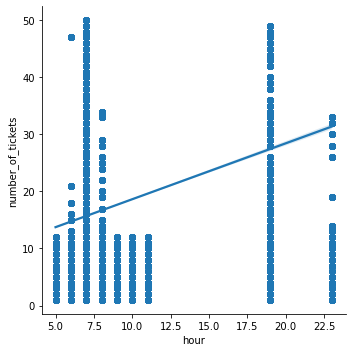

In [97]:
sns.lmplot(x="hour", y="number_of_tickets", data=all_data)

In [98]:
# Dropping the travel date column
all_data.drop("travel_date", axis = 1, inplace=True)
all_data.drop("travel_time", axis = 1, inplace=True)

In [99]:
# Convert Object to Category columns
cat_cols = all_data.select_dtypes(include=['object'],).columns
# Change columns to their respective datatypes
all_data[cat_cols] = all_data[cat_cols].astype('category')
# Confirm whether the changes have been successful
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51645 entries, 0 to 51644
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   ride_id            51645 non-null  int64   
 1   payment_method     51645 non-null  category
 2   travel_from        51645 non-null  category
 3   car_type           51645 non-null  category
 4   max_capacity       51645 non-null  int64   
 5   number_of_tickets  51645 non-null  float64 
 6   year               51645 non-null  int64   
 7   month              51645 non-null  int64   
 8   day                51645 non-null  int64   
 9   hour               51645 non-null  int64   
dtypes: category(3), float64(1), int64(6)
memory usage: 2.9 MB


In [100]:

all_data.head()

,ride_id,payment_method,travel_from,car_type,max_capacity,number_of_tickets,year,month,day,hour
0,1442,Mpesa,Migori,Bus,49,1.0,2017,10,290,7
1,5437,Mpesa,Migori,Bus,49,1.0,2017,11,323,7
2,5710,Mpesa,Keroka,Bus,49,1.0,2017,11,330,7
3,5777,Mpesa,Homa Bay,Bus,49,5.0,2017,11,331,7
4,5778,Mpesa,Migori,Bus,49,31.0,2017,11,331,7


#EDA

In [102]:
ptab = all_data.pivot_table(index='car_type', values='number_of_tickets', aggfunc='sum')
ptab

,number_of_tickets
car_type,
Bus,715417.0
shuttle,177056.0


In [103]:
all_data["car_type"].value_counts()

# The bus is the most preferred means of transport

Bus        31985
shuttle    19660
Name: car_type, dtype: int64

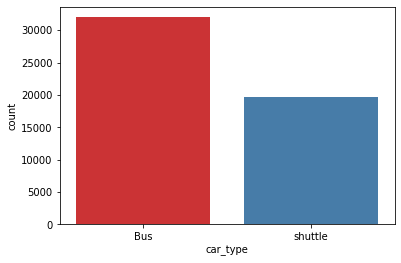

In [104]:
sns.countplot(x='car_type', 
              data = all_data,
              palette = 'Set1')

There are 2 car types the Bus and Shuttle with a capacity of 49 and 11
 respectively.


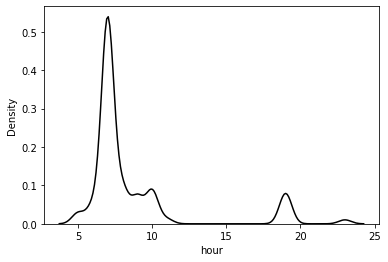

In [26]:
sns.kdeplot(x = 'hour' , data = all_data , color = 'black')

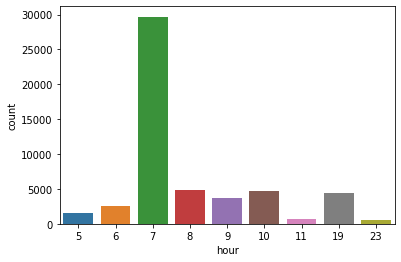

In [27]:
# Which is the most preferred travel time?

sns.countplot(x='hour', data=all_data)

Most customers travel at 7am

2. Which are top towns people come from?

In [28]:
x = all_data['travel_from'].value_counts()
x

Kisii        23152
Migori        7068
Homa Bay      6357
Sirare        4477
Rongo         4043
Kehancha      1941
Awendo        1832
Kijauri       1110
Keroka        1009
Nyachenge      546
Rodi           448
Mbita          403
Ndhiwa         265
Sori            65
Keumbu          22
Oyugis          17
Kendu Bay        1
Name: travel_from, dtype: int64

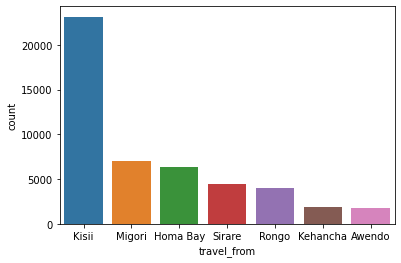

In [29]:
sns.countplot(x='travel_from', data=all_data, order=all_data.travel_from.value_counts().head(7).index)

3. which is the busiest month?

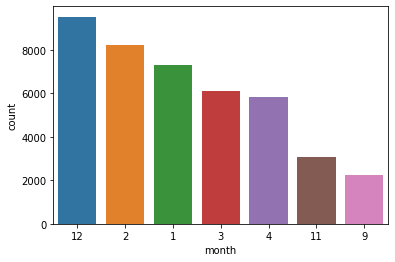

In [30]:
sns.countplot(x='month', data=all_data, order=all_data.month.value_counts().head(7).index)

In [70]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52756 entries, 0 to 52755
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   seat_number     51645 non-null  category
 1   payment_method  51645 non-null  category
 2   travel_from     52756 non-null  category
 3   travel_to       52756 non-null  category
 4   car_type        52756 non-null  category
 5   max_capacity    52756 non-null  int64   
 6   year            52756 non-null  int64   
 7   month           52756 non-null  int64   
 8   day             52756 non-null  int64   
 9   hour            52756 non-null  int64   
dtypes: category(5), int64(5)
memory usage: 2.3 MB


In [74]:
all_data['payment_method'].value_counts()

Mpesa    51532
Cash       113
Name: payment_method, dtype: int64

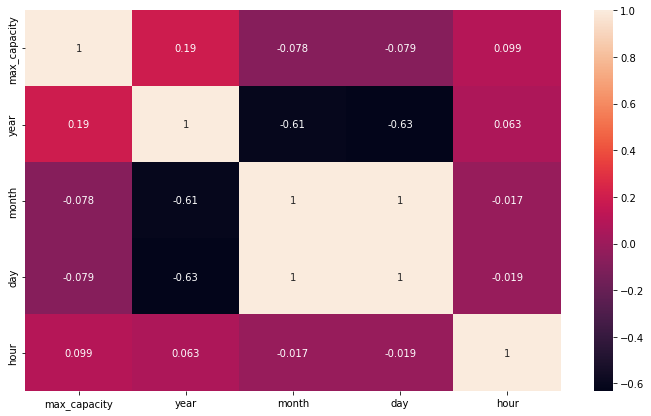

In [31]:
#Checking for feature correlation
plt.subplots(figsize=(12,7))
sns.heatmap(all_data.corr(method='pearson'), annot=True)

In [105]:
all_data.columns

Index(['ride_id', 'payment_method', 'travel_from', 'car_type', 'max_capacity',
       'number_of_tickets', 'year', 'month', 'day', 'hour'],
      dtype='object')

##Random Forest

In [182]:
#Separating features and labels
X = all_data[['travel_from', 'car_type', 'max_capacity',
       'year', 'month', 'day', 'hour']]
y =all_data['number_of_tickets']

In [183]:
X = pd.get_dummies(X)

In [184]:
#Split the data into a training set and testing set.
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [185]:
# We now need to perform feature scaling.
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [186]:
# Peforming LDA

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
lda = LDA()
X_train = lda.fit_transform(X_train, y_train)
X_test = lda.transform(X_test)

In [187]:
#Training and Making Predictions

from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)


In [188]:
mae = metrics.mean_absolute_error(y_test, y_pred)
mse = metrics.mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse) # or mse**(0.5)  
r2 = metrics.r2_score(y_test,y_pred)

print("Results of sklearn.metrics:")
print("MAE:",mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R-Squared:", r2)

Results of sklearn.metrics:
MAE: 2.9718975464358155
MSE: 27.058455942925203
RMSE: 5.201774307188385
R-Squared: 0.8253769193534111


R squared = 0.825


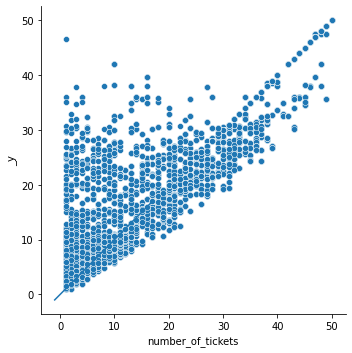

In [189]:
import seaborn as sns

sns.relplot(x=y_test, y=y_pred)

import matplotlib.pyplot as plt
plt.plot(np.linspace(-1, 17, 100),np.linspace(-1, 17, 100)) # add diagonal line

print('R squared =', round(np.corrcoef(y_test, y=y_pred)[0,1]**2,3))

##XGB

In [190]:
from xgboost import XGBRegressor

modelx = XGBRegressor(random_state=42, learning_rate=0.1, max_depth= 10, n_estimators=1000)
modelx.fit(X_train, y_train)
y_pred2 = modelx.predict(X_test)

[17:41:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [191]:
mae = metrics.mean_absolute_error(y_test, y_pred2)
mse = metrics.mean_squared_error(y_test, y_pred2)
rmse = np.sqrt(mse) # or mse**(0.5)  
r2 = metrics.r2_score(y_test,y_pred2)

print("Results of sklearn.metrics:")
print("MAE:",mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R-Squared:", r2)

Results of sklearn.metrics:
MAE: 2.9544970699831135
MSE: 26.878376958828976
RMSE: 5.184436030932292
R-Squared: 0.8265390679634027


R squared = 0.827


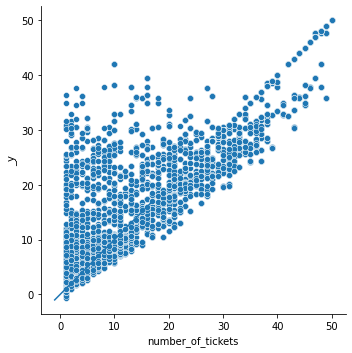

In [192]:
import seaborn as sns

sns.relplot(x=y_test, y=y_pred2)

import matplotlib.pyplot as plt
plt.plot(np.linspace(-1, 17, 100),np.linspace(-1, 17, 100)) # add diagonal line

print('R squared =', round(np.corrcoef(y_test, y=y_pred2)[0,1]**2,3))

In [174]:
# A parameter grid for XGBoost
param_grid = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

In [181]:
from sklearn.model_selection import GridSearchCV
grid = GridSearchCV( XGBRegressor(random_state=42, learning_rate=0.1, max_depth= 10, n_estimators=50), param_grid)
from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
grid.fit(X_train, y_train)
# print(grid.score(xvalid, yvalid))
print(grid.best_params_)
print(grid.best_score_)

[17:27:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:27:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:27:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:27:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:27:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:27:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:27:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:27:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

KeyboardInterrupt: ignored

In [140]:
modelx.feature_importances_

array([0.3643219 , 0.10696297, 0.04229978, 0.05359033, 0.03553979,
       0.04106957, 0.02166936, 0.02844705, 0.01227706, 0.0227729 ,
       0.0197899 , 0.01321996, 0.01346371, 0.03846417, 0.01355553,
       0.01562296, 0.01473248, 0.02129326, 0.01953538, 0.01236636,
       0.03857893, 0.01448552, 0.03594112], dtype=float32)

In [180]:
import numpy as np
import pandas as pd
# import hvplot.pandas

# df = pd.DataFrame(np.random.randn(100, 6), columns=['a', 'b', 'c', 'd', 'e', 'f'])

# notice argument backend='plotly' to change the plotting backend of pandas
all_data.plot(
    kind='scatter',
    x=y_test, 
    y= y_pred2, 
    backend='plotly', 
    width=500,   
)